In [1]:
import transformers
from transformers import AutoTokenizer, AutoModel
import re
import tqdm
import numpy as np
import torch
from torch.nn import CosineSimilarity
import pandas as pd

model_name = 'SZTAKI-HLT/hubert-base-cc'
  
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

Some weights of the model checkpoint at SZTAKI-HLT/hubert-base-cc were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)


def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
    Select only those subword token outputs that belong to our word of interest
    and average them."""
    with torch.no_grad():
        output = model(**encoded)

    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]

    return word_tokens_output.mean(dim=0)


def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
    that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer(sent, return_tensors="pt")
    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)

    return get_hidden_states(encoded, token_ids_word, model, layers)

def get_word_vector_for_idx(sent, word_idx, tokenizer, model, layers):
    encoded = tokenizer(sent, return_tensors="pt")
    token_ids_word = np.where(np.isin(encoded.word_ids(), word_idx))
    
    return get_hidden_states(encoded, token_ids_word, model, layers)

def get_context(sent, idx, window=2):
    segmented_sen = sent.split(' ')
    return segmented_sen[max((idx-window), 0):idx] + segmented_sen[idx+1:min((idx+window+1, len(segmented_sen)))]

def get_context_idx(sent, idx, window=2):
    segmented_sen = sent.split(' ')
    return list(range(max((idx-window), 0), idx)) + list(range(idx+1, min((idx+window+1, len(segmented_sen)))))

def get_context_vector(sent, idx, window, tokenizer, model, layers):
    context_idx = get_context_idx(sent, idx, window)
    encoded = tokenizer(sent, return_tensors="pt")
    # get all token idxs that belong to the word of interest
    token_ids_words = [np.where(np.array(encoded.word_ids()) == idx) for idx in context_idx]
    vectors = [get_hidden_states(encoded, token_ids_word, model, layers) for token_ids_word in token_ids_words]
    return torch.mean(torch.stack(vectors), dim=0)

In [7]:
corpus = []
with open('corp_tok.spl') as f:
    for line in map(str.strip, f):
        corpus += [line]

In [8]:
subword = r'nem'
context_size = 3
layers = [12]

vectors = {}
context_vectors = {}
context_words = {}


for sent_id, sentence in tqdm.tqdm(enumerate(corpus), total=len(corpus)):
    for i, word in enumerate(sentence.split(' ')):
        if re.match(subword, word):
            vectors[sent_id, i, word] = get_word_vector(sentence, i, tokenizer, model, layers).numpy()
            context_vectors[sent_id, i, word] = get_context_vector(sentence, i, context_size, tokenizer, model, layers).numpy()
            context_words[sent_id, i, word] = get_context(sentence, i, context_size)

100%|██████████| 99/99 [00:20<00:00,  4.90it/s]


In [9]:
import sklearn.manifold, sklearn.decomposition, sklearn.cluster
import plotly.express as px

In [10]:
# learning dimensionality reduction because we can't really use 768 dim vectors
pca = sklearn.decomposition.PCA(n_components=30)
pca.fit(np.stack(list(vectors.values())))

PCA(n_components=30)

In [11]:
example_vector = vectors[(4, 16, 'nem')]
pca.transform(example_vector.reshape(1, -1))

array([[-4.7012625 ,  0.36052045,  0.92070794,  0.23657481,  0.11899285,
         0.31753826, -0.8868038 , -0.955982  ,  1.123457  ,  0.2704324 ,
         1.2219805 ,  0.45535448, -0.6826393 ,  0.91192764, -1.7593709 ,
         0.21240334, -1.2616678 ,  3.1292596 , -0.77253914, -2.5699382 ,
         1.0290556 , -1.4750029 , -1.4583855 , -2.0707898 , -1.7099284 ,
         1.2194908 ,  0.60409516,  1.0455613 ,  1.1871333 ,  0.14247024]],
      dtype=float32)

In [12]:
word_ids = sorted(vectors.keys(), key = lambda x: x[2])

In [13]:
df_data = []
for sent_id, word_id, word in word_ids:
    cur_line = [sent_id, word_id, word]
    cur_line += [context_words[(sent_id, word_id, word)]]
    df_data += [cur_line]
    

In [14]:
# we reshape to 768-long, 1 width 2 dimensional arrays, then stack them, so we get an array of items by dimension size
pca_vectors = np.stack([pca.transform(vectors[word].reshape(1, -1)).flatten() for word in word_ids], axis=0)
pca_context_vectors = np.stack([pca.transform(context_vectors[word].reshape(1, -1)).flatten() for word in word_ids], axis=0)
pca_vectors.shape

(39, 30)

In [15]:
tsne_pca = sklearn.manifold.TSNE(n_components=2, random_state=0)
tsne_context = sklearn.manifold.TSNE(n_components=2, random_state=1)

In [16]:
projections = tsne_pca.fit_transform(pca_vectors)
projections_context = tsne_context.fit_transform(pca_context_vectors)

In [43]:
df = pd.DataFrame(data = df_data, columns = ['sent_id', 'word_id', 'word', 'context'])
kmeans = sklearn.cluster.KMeans(n_clusters=3)
kmeans.fit(pca_vectors)
labels = kmeans.predict(pca_vectors)
df['cluster'] = labels.astype(str).tolist()

In [44]:
kmeans_context = sklearn.cluster.KMeans(n_clusters=3)
kmeans_context.fit(pca_context_vectors)
context_labels = kmeans_context.predict(pca_context_vectors)
df['context_label'] = context_labels.astype(str).tolist()

In [45]:
df['tsne_x'] = projections[:, 0].tolist()
df['tsne_y'] = projections[:, 1].tolist()
df['tsne_context_x'] = projections_context[:, 0].tolist()
df['tsne_context_y'] = projections_context[:, 1].tolist()

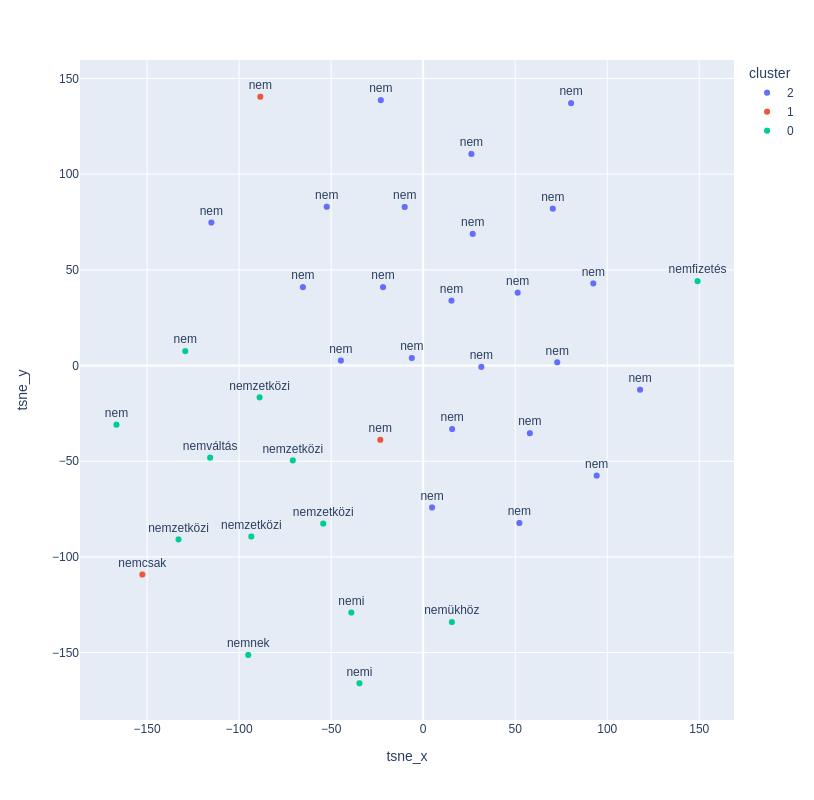

In [46]:
fig = px.scatter(data_frame = df, x='tsne_x', y='tsne_y', color='cluster', 
                 hover_data=['sent_id', 'word_id', 'word', 'context'],
                 text='word', width=800, height=800)

fig.update_traces(textposition='top center')

fig.show()


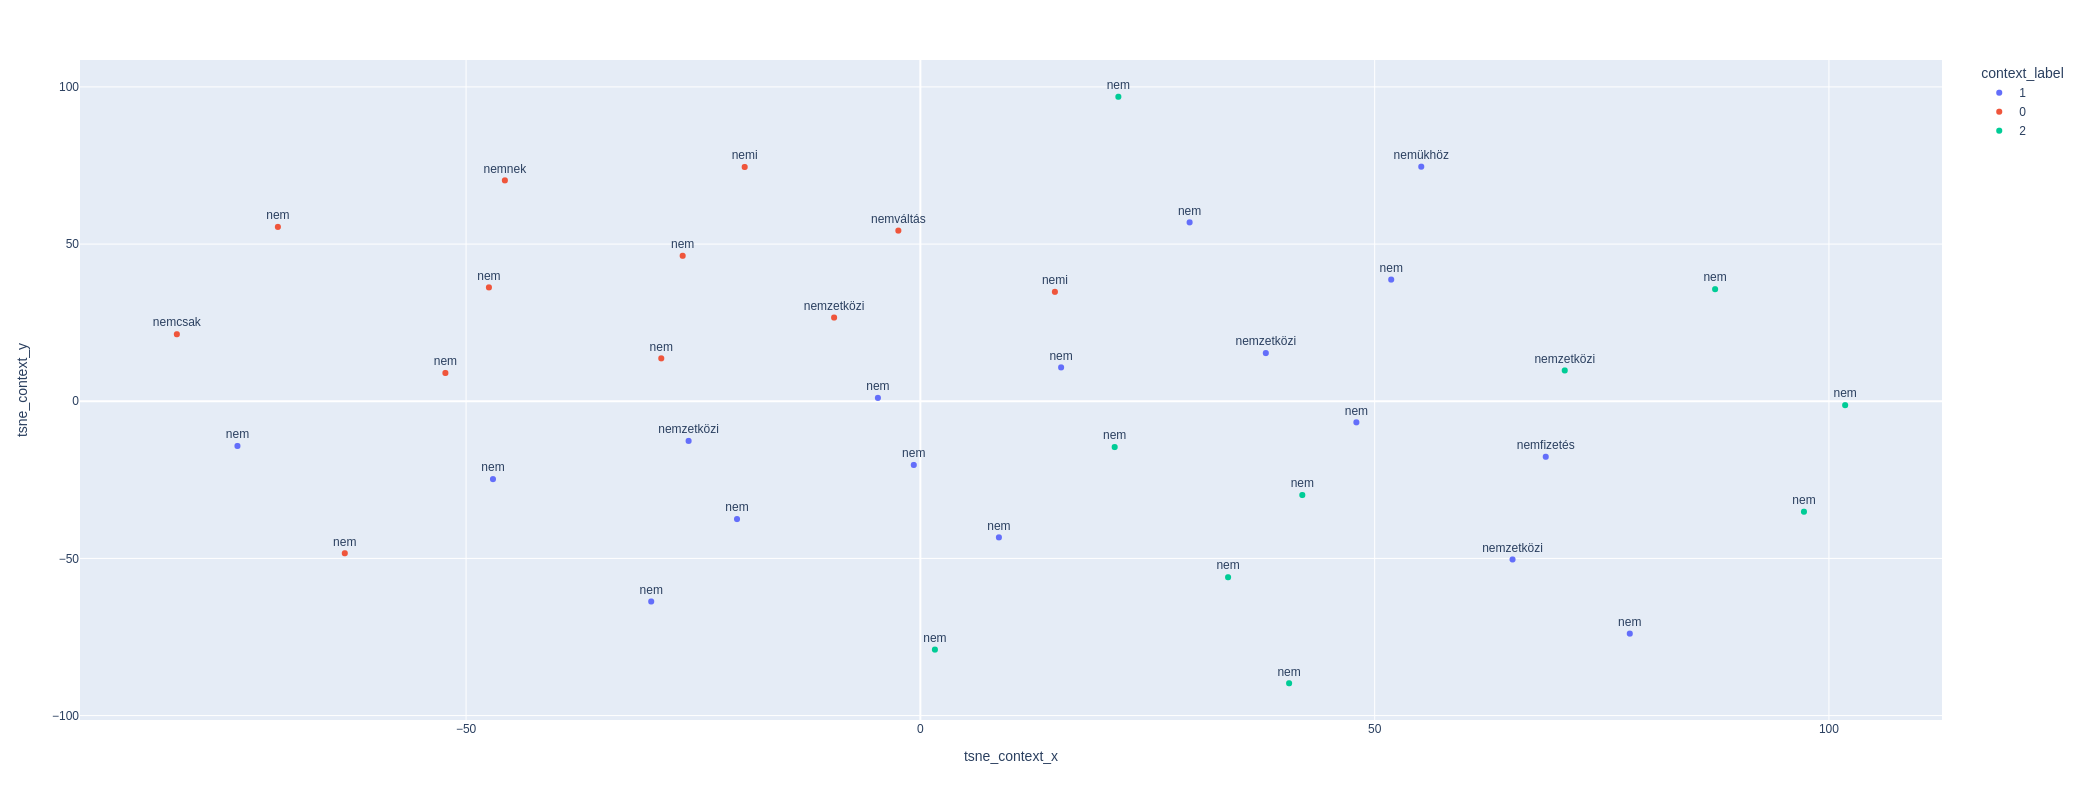

In [28]:
fig = px.scatter(data_frame = df, x='tsne_context_x', y='tsne_context_y', color='context_label', hover_data=['sent_id', 'word_id', 'word', 'context'], text='word', width=800, height=800)

fig.update_traces(textposition='top center')


fig.show()


In [177]:
tokenizer(corpus[0], return_tensors='pt')

{'input_ids': tensor([[    2, 13083,  2094,  2218,  2105, 31741,  2163,  5266,  2422, 31388,
          2091,  2114,  2005,  9834,  6120,  8029,  2034, 12118,  4883,  4779,
          4729, 30193,  5539, 12876,  3646, 17559, 31744, 19820, 27465,  8595,
          5247,  5189, 31749,  3576,  2788, 10620,  2094,  2066,  2005,  5039,
          2249, 15592, 31739,  3408,  2111,  2024, 26507,  2114, 10979,  3119,
          9686,  2964, 16902,  2052,  2005, 10369,  4575,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}